\begin{center}
Gabe Morris
\end{center}

In [1]:
# Imports
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
from msu_esd import Pipe
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Latex
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

plt.style.use('maroon_ipynb.mplstyle')

\pagebreak
\tableofcontents
\pagebreak

# Given
From Project 1, piping and pump requirements for a chilled fluid circulating system for a portion of the Orlando Airport were determined. A Z-network was used for the system, and the pumps head and flow rate requirements were found.

## Project 1 Overview
From Project 1, the booster pump option was selected because it was more cost-efficient and offered more control over the system. The schematic is shown in Figure 1.

\begin{center}
\includegraphics{images/fig1} \\
Figure 1: Booster Pump Schematic
\end{center}

The resulting head values are $b_2=67.65\,ft$, $b_4=101.95\,ft$, $b_7=55.7\,ft$, and $b_{10}=44.9\,{ft}$. The main line pump has a head of $W_s=145\,ft$. The summary of the piping lengths as well as material properties are given in Table 1.

\begin{center}
Table 1: Summary of Piping
\end{center}

| Pipe | L (ft) | D (in) | # Valves | # Elbows | K    | C   |
|------|--------|--------|----------|----------|------|-----|
| 1    | 2840   | 18.812 | 1        | 0        | 1.78 | 8   |
| 2    | 2380   | 10.02  | 1        | 5        | 5.53 | 8   |
| 3    | 1300   | 11.938 | 1        | 0        | 1.78 | 8   |
| 4    | 1630   | 10.02  | 1        | 5        | 5.53 | 8   |
| 5    | 3000   | 11.938 | 1        | 2        | 3.28 | 8   |
| 6    | 5000   | 11.938 | 1        | 2        | 3.28 | 8   |
| 7    | 1580   | 11.938 | 1        | 0        | 1.78 | 8   |
| 8    | 1550   | 7.981  | 1        | 5        | 5.53 | 8   |
| 9    | 1550   | 7.981  | 1        | 7        | 7.03 | 8   |
| 10   | 5130   | 10.02  | 1        | 8        | 7.78 | 8   |
| 11   | 1875   | 11.938 | 1        | 1        | 2.53 | 8   |

\begin{center}
Material: Galvanized Steel (Schedule 40) \\
Absolute Roughness: $\epsilon=0.0005\,ft$ \\
Working Fluid: Therminol D-12 \\
Density: $\rho=48.05\frac{lbm}{ft^3}$ \\
Heat Capacity: $c_p=0.491\frac{Btu}{lbm^\circ F}$ \\
Viscosity: $\mu=3.715\frac{lbm}{ft\,hr}$
\end{center}

The system of equations using the Kirchhoff method is,

$$\begin{cases}
Q_1=Q_3+Q_2 \\
Q_3=Q_4+Q_5 \\
Q_6=Q_2+Q_4 \\
Q_5=Q_7+Q_{10} \\
Q_7=Q_8+Q_9 \\
Q_{11}=Q_6+Q_7 \\
h_2+K_1Q_2|Q_2|+h_6+h_{11}+h_1-145+0.1Q_1|Q_1|-b_2=0 \\
h_4+K_3Q_4|Q_4|-h_2-K_1Q_2|Q_2|+h_3+b_2-b_4=0 \\
h_7+h_8+K_4Q_8|Q_8|-h_6-h_4-K_3Q_4|Q_4|+h_5+b_4-b_7=0 \\
h_9+K_4Q_9|Q_9|-h_8-K_4Q_8|Q_8|=0 \\
h_{10}+K_2Q_{10}|Q_{10}|-h_{11}-h_7-h_9-K_4Q_9|Q_9|+b_7-b_{10}=0
\end{cases}$$

The code block below outputs the flow rates for this system.

In [2]:
# Define known constants
K1, K2, K3, K4 = 4.5, 4.5, 4.5, 10  # Loss coefficients

rho = 48.05/32.174  # In slugs per cubic feet
mu = 3.715/(3600*32.174)  # In slugs per (ft s) or lbf*s per ft squared
epsilon = 0.0005  # In ft

D20, D12, D10, D8 = np.array([18.812, 11.938, 10.02, 7.981])/12  # Diameters in ft

Ws = 145  # in ft

# Define pipe objects
p1 = Pipe(D20, 2840, epsilon, rho, mu, K=1.78, C=8)
p2 = Pipe(D10, 2380, epsilon, rho, mu, K=5.53, C=8)
p3 = Pipe(D12, 1300, epsilon, rho, mu, K=1.78, C=8)
p4 = Pipe(D10, 1630, epsilon, rho, mu, K=5.53, C=8)
p5 = Pipe(D12, 3000, epsilon, rho, mu, K=3.28, C=8)
p6 = Pipe(D12, 5000, epsilon, rho, mu, K=3.28, C=8)
p7 = Pipe(D12, 1580, epsilon, rho, mu, K=1.78, C=8)
p8 = Pipe(D8, 1550, epsilon, rho, mu, K=5.53, C=8)
p9 = Pipe(D8, 1550, epsilon, rho, mu, K=7.03, C=8)
p10 = Pipe(D10, 5130, epsilon, rho, mu, K=7.78, C=8)
p11 = Pipe(D12, 1875, epsilon, rho, mu, K=2.53, C=8)

def balanced(x, b2, b4, b7, b10):
    Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11 = x
    # all expressions need to be set to zero
    return [
        Q1 - Q2 - Q3,
        Q6 - Q2 - Q4,
        Q3 - Q4 - Q5,
        Q5 - Q10 - Q7,
        Q7 - Q8 - Q9,
        Q11 - Q6 - Q7,
        K1*Q2*abs(Q2) + p2.h(Q2) + p6.h(Q6) + p11.h(Q11) + p1.h(Q1) - Ws + 0.1*Q1*abs(Q1) - b2,
        p4.h(Q4) + K3*Q4*abs(Q4) - p2.h(Q2) - K1*Q2*abs(Q2) + p3.h(Q3) + b2 - b4,
        p7.h(Q7) + p8.h(Q8) + K4*Q8*abs(Q8) - p6.h(Q6) - p4.h(Q4) - K3*Q4*abs(Q4) + p5.h(Q5) + b4 - b7,
        p9.h(Q9) + K4*Q9*abs(Q9) - p8.h(Q8) - K4*Q8*abs(Q8),
        p10.h(Q10) + K2*Q10*abs(Q10) - p11.h(Q11) - p9.h(Q9) - K4*Q9*abs(Q9) - p7.h(Q7) + b7 - b10
    ]

Q_guess = np.array([5, 1, 4, 2, 2, 3, 1, 3, -2, 1, 4])  # This does satisfy mass conservation
b = 67.65, 101.95, 55.7, 44.9
balanced_solution = fsolve(balanced, Q_guess, args=(*b, ))
balanced_solution  # flow rates in ft^3/s

array([10.69253924,  2.71300891,  7.97953032,  2.7132475 ,  5.26628283,
        5.42625641,  2.55233847,  1.27984524,  1.27249323,  2.71394436,
        7.97859488])

# Find
Using the results from Project 1 and the Goulds handout, accomplish the following:

a. Are viscous fluid pump corrections needed?
b. Select the required main-line pump (company, model number, RPM, rotor diameter). A copy of the manufacturer’s pump performance information is needed in the report. If booster pumps are used, then continue to use the same booster pumps increases in head as in Project 1 (the corrected version), but you do not need to specify an exact model.
c. Generate a curve fit for H vs. Q for the main-line pump of part (b). Verify using the Hardy-Cross or Kirchhoff program that the selected pump is suitable. This means that the H-Q curve fit is to be placed in the Hardy-Cross or Kirchhoff program and the resulting flow rates in the individual loads are to be computed and compared with the required flow rates. Compute the power required for the pump including viscous corrections, if needed.
d. The management team also wants a parallel pump arrangement, using identical pumps, for the main line to be examined. Booster pumps, if used, are the same as in Part (b). Select the required pump (model number, RPM, rotor diameter). A copy of the manufacturer’s pump performance information is needed. Use the Hardy-Cross or Kirchhoff program to find the behavior of the system with (1) both pumps in parallel and (2) only one of the parallel pumps in operation. This gives some idea of the system capability of the parallel arrangement if one pump is down. For the parallel analysis, determine the power required (including viscous corrections, if needed) for the two parallel pump operating conditions.
e. Provide a summary of the recommended pumps for the system including the system capacity when only one of the pumps in the parallel configuration is operating. A recommendation as to which arrangement to use, single main pump or parallel main pumps, is desired.

# Solution
## Part A
The first step for determining whether viscous effects are negligible is to acquire the SSU viscosity. The code block below contains the function for finding the SSU viscosity, given the kinematic viscosity. This was added to the `msu_esd` package, but is shown here for convenience.

In [3]:
def SSU(nu):
    """
    Returns the Saybolt Seconds Universal value of viscosity.

    :param nu: The kinematic viscosity in ft^2/s
    :return: SSU value
    """
    guess = 100
    stoke = 1e-4  # m^2/s
    nu = nu/3.28084**2  # converts to m^2/s

    if nu < 0.2065*stoke:
        return fsolve(lambda ssu: nu - 0.00226*stoke*ssu + 1.95*stoke/ssu, np.array([guess, ]))[0]
    else:
        return fsolve(lambda ssu: nu - 0.0022*stoke*ssu + 1.35*stoke/ssu, np.array([guess, ]))[0]

The kinematic viscosity is,

$$\nu=\frac{\mu}{\rho}=\frac{3.715\,\frac{lbm}{ft\,hr}}{48.05\,\frac{lbm}{ft^3}}=2.148\cdot10^-5\,\frac{ft^2}{s}$$

In [4]:
kin_viscosity = mu/rho
ssu_viscosity = SSU(kin_viscosity)
ssu_viscosity

34.11804944489399

Thus, the SSU value for viscosity is around 34. The flow rate across the main pump is $10.7\,\frac{ft^3}{s}$, which is 4800 gallons per minute. Figure 2 below shows the relationship and procedure for determining the correction factors.

\begin{center}
\includegraphics{images/fig2} \\
Figure 2: Correction Factors
\end{center}

The results show that the correction factors are close to 100% for the head, flow rate, and efficiency because the viscosity of water is low; therefore, **the viscous correction factors are negligible**.

## Part B
Figure 3 below is a good starting point for determining which pump to select. With a head requirement of 145 ft and a flow rate of 4800 gallons per minute, the 8x10-17 is a starting point.

\begin{center}
\includegraphics{images/fig3} \\
Figure 3: Model 3196 Pump Selections
\end{center}

Figure 4 below shows the breakdown of the 8x10-17 pump selection with the head and flow rate requirements shown.

\begin{center}
\includegraphics{images/fig4} \\
Figure 4: 8x10-17 Performance
\end{center}

While this certainly is a consideration, there is one other option to choose from. The 8x10-16H shown in Figure 5 should also be considered.

\begin{center}
\includegraphics{images/fig5} \\
Figure 5: 8x10-16H Performance
\end{center}

The choice between the two should be determined based on the efficiency of the pump. For the 8x10-17, the efficiency shown in Figure 4 is below 80%, but for the 8x10-16H, the efficiency is closer to 82%; therefore, the 8x10-16H will be selected as the main pump. The specifications of this selection are shown in Table 2.

\begin{center}
Table 2: Goulds Pump Information
\end{center}

| Specification  | Value    |
|----------------|----------|
| Model Number   | 3196     |
| Size           | 8x10-16H |
| Speed          | 1785 RPM |
| Rotor Diameter | 15"      |

## Part C
The graph of the head versus the flow rate may be acquired from Figure 5 using [this tool](https://apps.automeris.io/wpd/), which is able to extract data from an image.

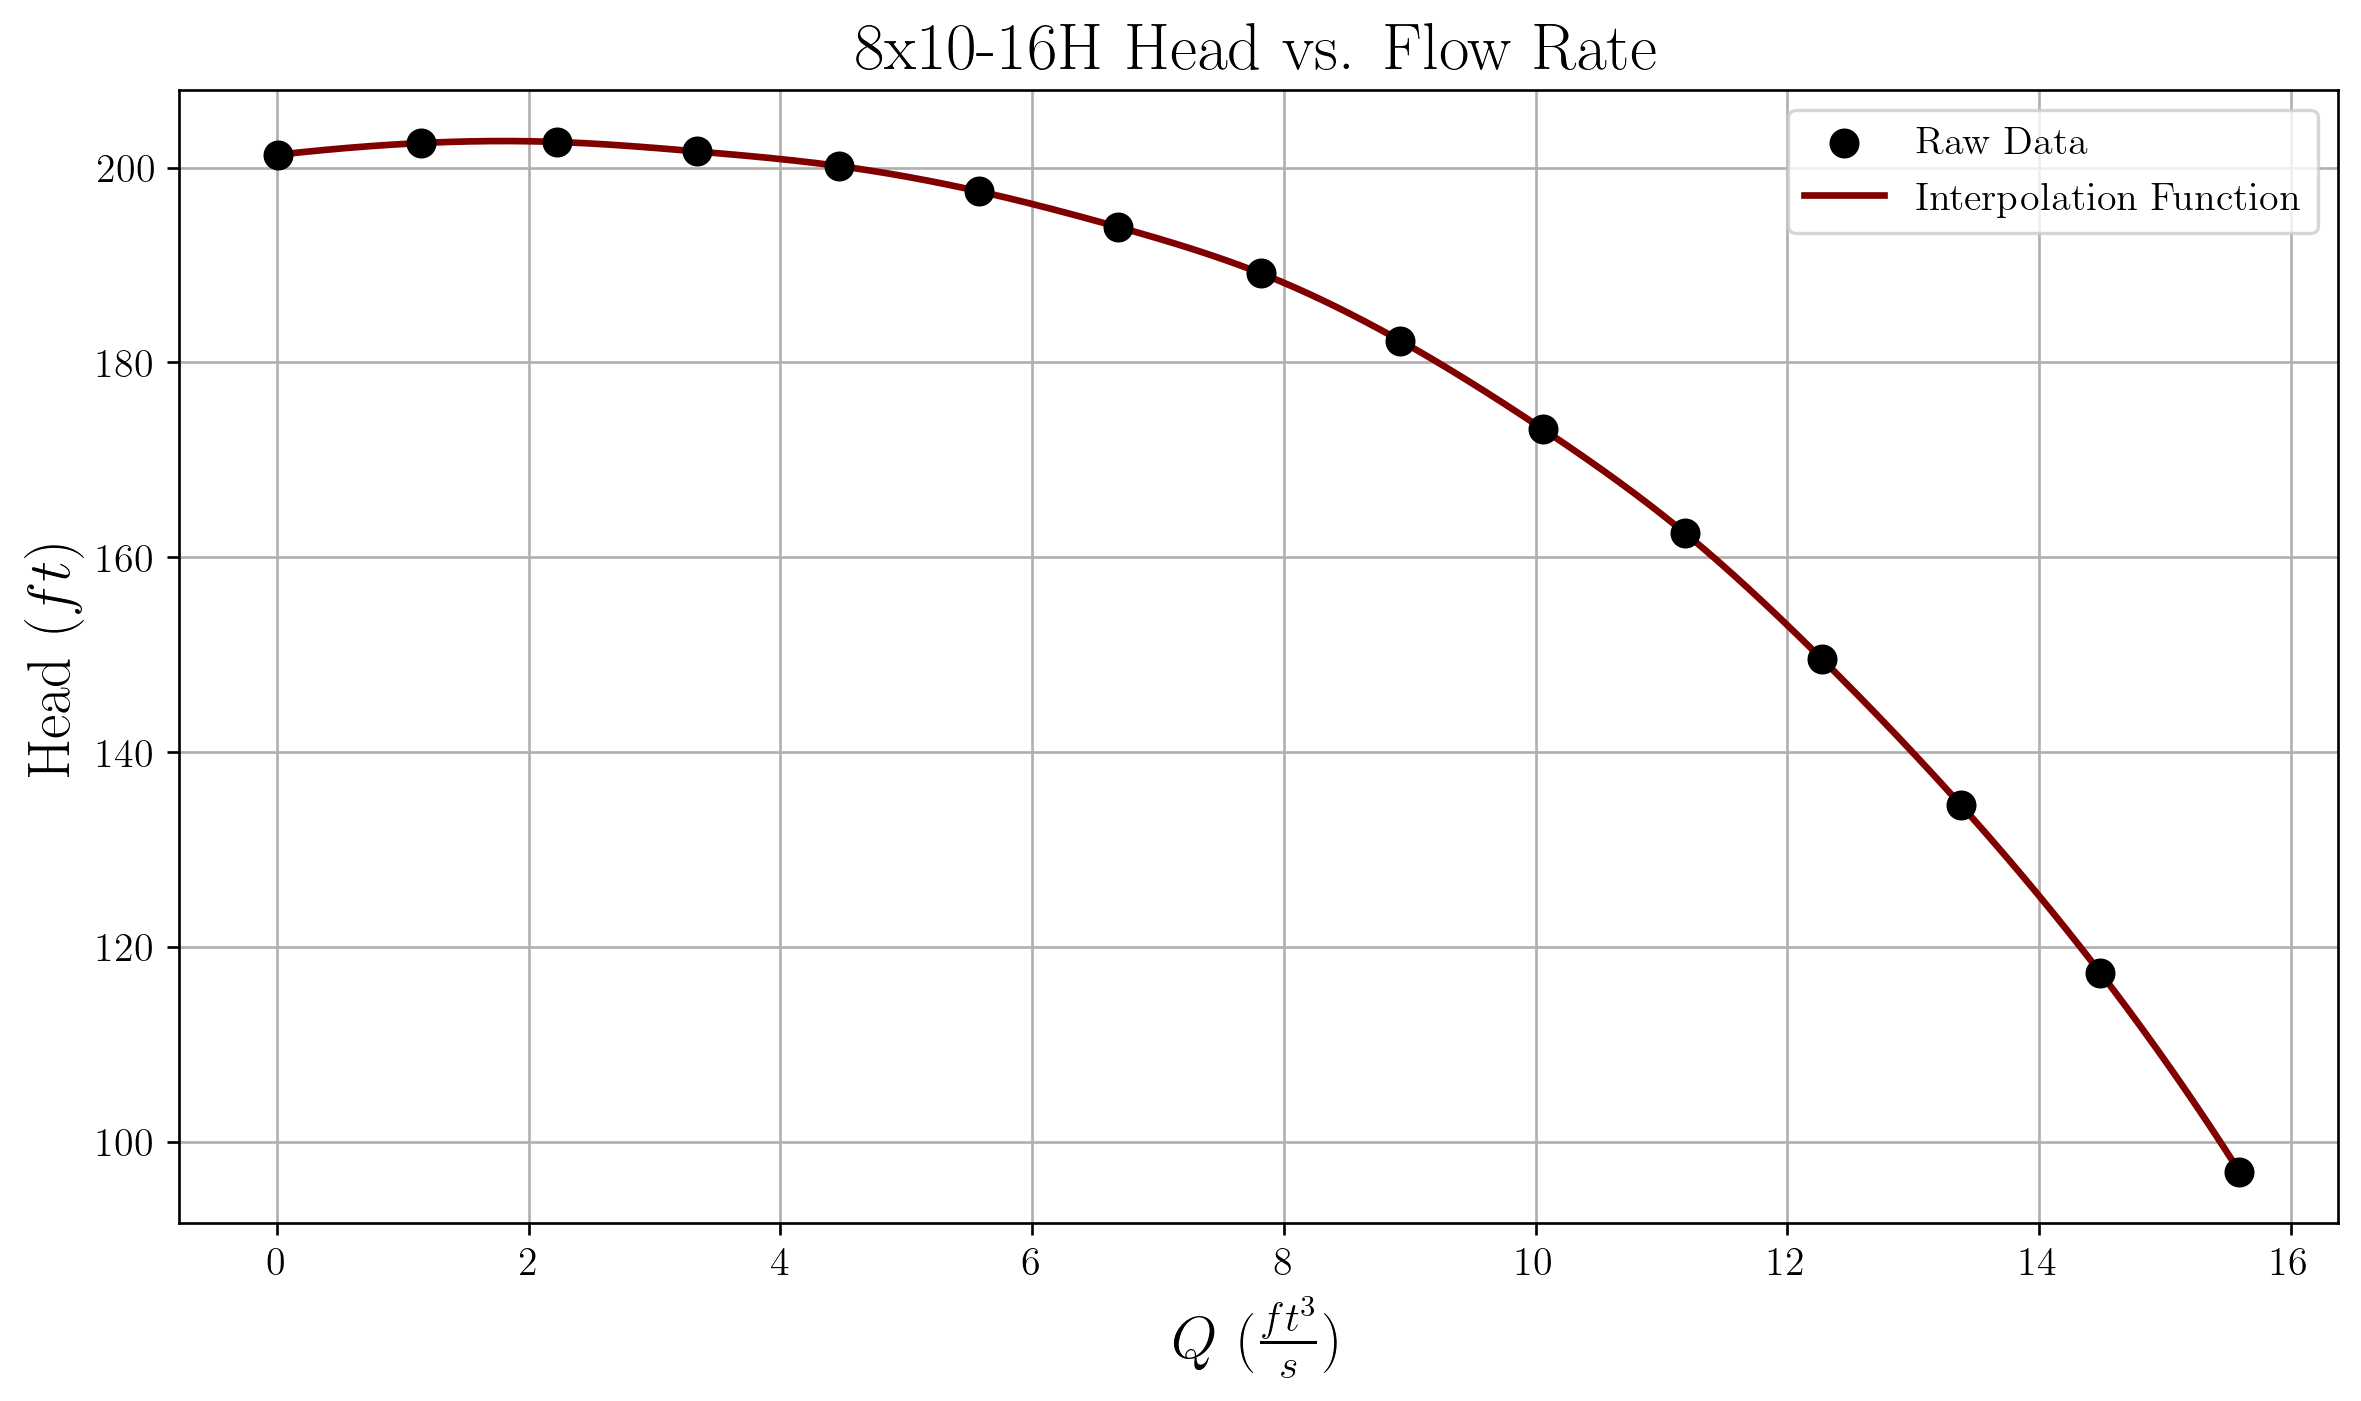

In [5]:
flow_rates = np.array([3.531757334093072, 512.2795025159023, 998.8569258520843, 1496.4397607519227, 2005.0545903351372, 2502.557675875819, 3000.0075951770627, 3508.462926041963, 4005.753346624893, 4513.996012532041, 5022.158929080035, 5508.09835754296, 6004.990031330106, 6501.775372638374, 6998.40121522833])/(7.48052*60)  # ft^3/sec

heads = np.array([201.32412418114492, 202.52378239817713, 202.63657077755624, 201.67017943605805, 200.1654799202506, 197.57647393904867, 193.90572486471086, 189.15579606949584, 182.23981771575043, 173.16291654799198, 162.46340074052972, 149.59527200227853, 134.56622045001419, 117.37368271147818, 96.93591569353458])  # ft

Ws_lamb = interp1d(flow_rates, heads, kind='cubic', fill_value='extrapolate')
Q_values = np.linspace(0, flow_rates[-1], 1000)

plt.scatter(flow_rates, heads, zorder=3, color='black', label='Raw Data')
plt.plot(Q_values, Ws_lamb(Q_values), label='Interpolation Function')
plt.xlabel(r'$Q$ ($\frac{ft^3}{s}$)')
plt.ylabel(r'Head ($ft$)')
plt.title('8x10-16H Head vs. Flow Rate')
plt.legend()
plt.show()

The flow rates may now be computed again, but this time, the head is a function of the flow rate. If the head values for the booster pumps remain, then the first loop equation is all that needs to be adjusted (just the $W_s$ term).

In [6]:
def rating_1785(x, b2, b4, b7, b10):
    Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11 = x
    # all expressions need to be set to zero
    return [
        Q1 - Q2 - Q3,
        Q6 - Q2 - Q4,
        Q3 - Q4 - Q5,
        Q5 - Q10 - Q7,
        Q7 - Q8 - Q9,
        Q11 - Q6 - Q7,
        K1*Q2*abs(Q2) + p2.h(Q2) + p6.h(Q6) + p11.h(Q11) + p1.h(Q1) - Ws_lamb(Q1) + 0.1*Q1*abs(Q1) - b2,
        p4.h(Q4) + K3*Q4*abs(Q4) - p2.h(Q2) - K1*Q2*abs(Q2) + p3.h(Q3) + b2 - b4,
        p7.h(Q7) + p8.h(Q8) + K4*Q8*abs(Q8) - p6.h(Q6) - p4.h(Q4) - K3*Q4*abs(Q4) + p5.h(Q5) + b4 - b7,
        p9.h(Q9) + K4*Q9*abs(Q9) - p8.h(Q8) - K4*Q8*abs(Q8),
        p10.h(Q10) + K2*Q10*abs(Q10) - p11.h(Q11) - p9.h(Q9) - K4*Q9*abs(Q9) - p7.h(Q7) + b7 - b10
    ]

solution_1785 = fsolve(rating_1785, Q_guess, args=(*b, ))
solution_1785  # cfs

array([11.15358038,  2.84791583,  8.30566455,  2.77622447,  5.52944008,
        5.6241403 ,  2.68007152,  1.34390004,  1.33617148,  2.84936856,
        8.30421182])

The actual flow rates and the required flow rates may be compared using the percent change method,

$$\%\ change=\frac{actual-original}{original}\cdot100$$

In [7]:
(solution_1785 - balanced_solution)/balanced_solution*100

array([4.31180223, 4.97259406, 4.0871356 , 2.32109213, 4.99702085,
       3.6467848 , 5.00454977, 5.00488648, 5.0042111 , 4.98994025,
       4.08113143])

All the flow rates appear to be within 5% of the original, which is not too excessive. What is important to take out of this is that all the flow rates are greater than the original, meaning this pump will be able to meet the minimum requirements from Project 1. It should also be noted that these flow rates are based on the typical rating of the pump at 1785 RPM. This doesn't mean that the pump has to operate at the ratings calculated above because pumps can be controlled. This pump could be dialed down to stay within the boundaries that were determined from Project 1. The graph shown in Figure 5 is for a rotor speed of 1785 RPM, but since the speed can be changed and slowed down, then there are an infinite amount of Head vs. Flow Rate graphs. One of these speeds can meet the exact requirements specified from Project 1.

The required power for the main line using the conservative flow rates just calculated is,

$$power=\frac{\rho QW_s}{\eta}$$

where $\eta$ may be taken to be 82%, which is the efficiency in Figure 5 along the 15" line. $W_s$ is in the head form, which means that it is in units of $ft$. In order to change the form to reflect that shown in the energy balance equation, $W_s$ must be multiplied by $g$ to have units of $\frac{ft^2}{s^2}$ (if $\rho$ is in $\frac{slugs}{ft^3}$ like below).

In [8]:
eta = 0.82
power = (rho*solution_1785[0]*Ws_lamb(solution_1785[0])*32.174)/eta
power_hp_1785 = power/550
power_hp_1785  # hp

193.5092485914832

Thus, the power required to push the fluid at this flow rate is 194 hp.

## Part D
For pumps in parallel, the flow rate across each pump decreases by a half. This means that the working flow rate is $\frac{4800}{2}=2400\,gpm$. Figure 6 shows some selections from model 3196.

\begin{center}
\includegraphics{images/fig6} \\
Figure 6: Model 3196 Pump Selections
\end{center}

For this case, the 8x10-13 is the only worthy option. Figure 7 shows the performance with the required flow rate and head operating at around 79.5% efficiency.

\begin{center}
\includegraphics{images/fig7} \\
Figure 7: 8x10-13 Performance
\end{center}

Table 3 shows the specifications for the parallel selection.

\begin{center}
Table 3: Goulds Pump Information for Parallel
\end{center}

| Specification  | Value    |
|----------------|----------|
| Model Number   | 3196     |
| Size           | 8x10-13  |
| Speed          | 1780 RPM |
| Rotor Diameter | 13.25"   |

Now, the relationship between the head and flow rate may be acquired from the raw data and placed inside an interpolation function.

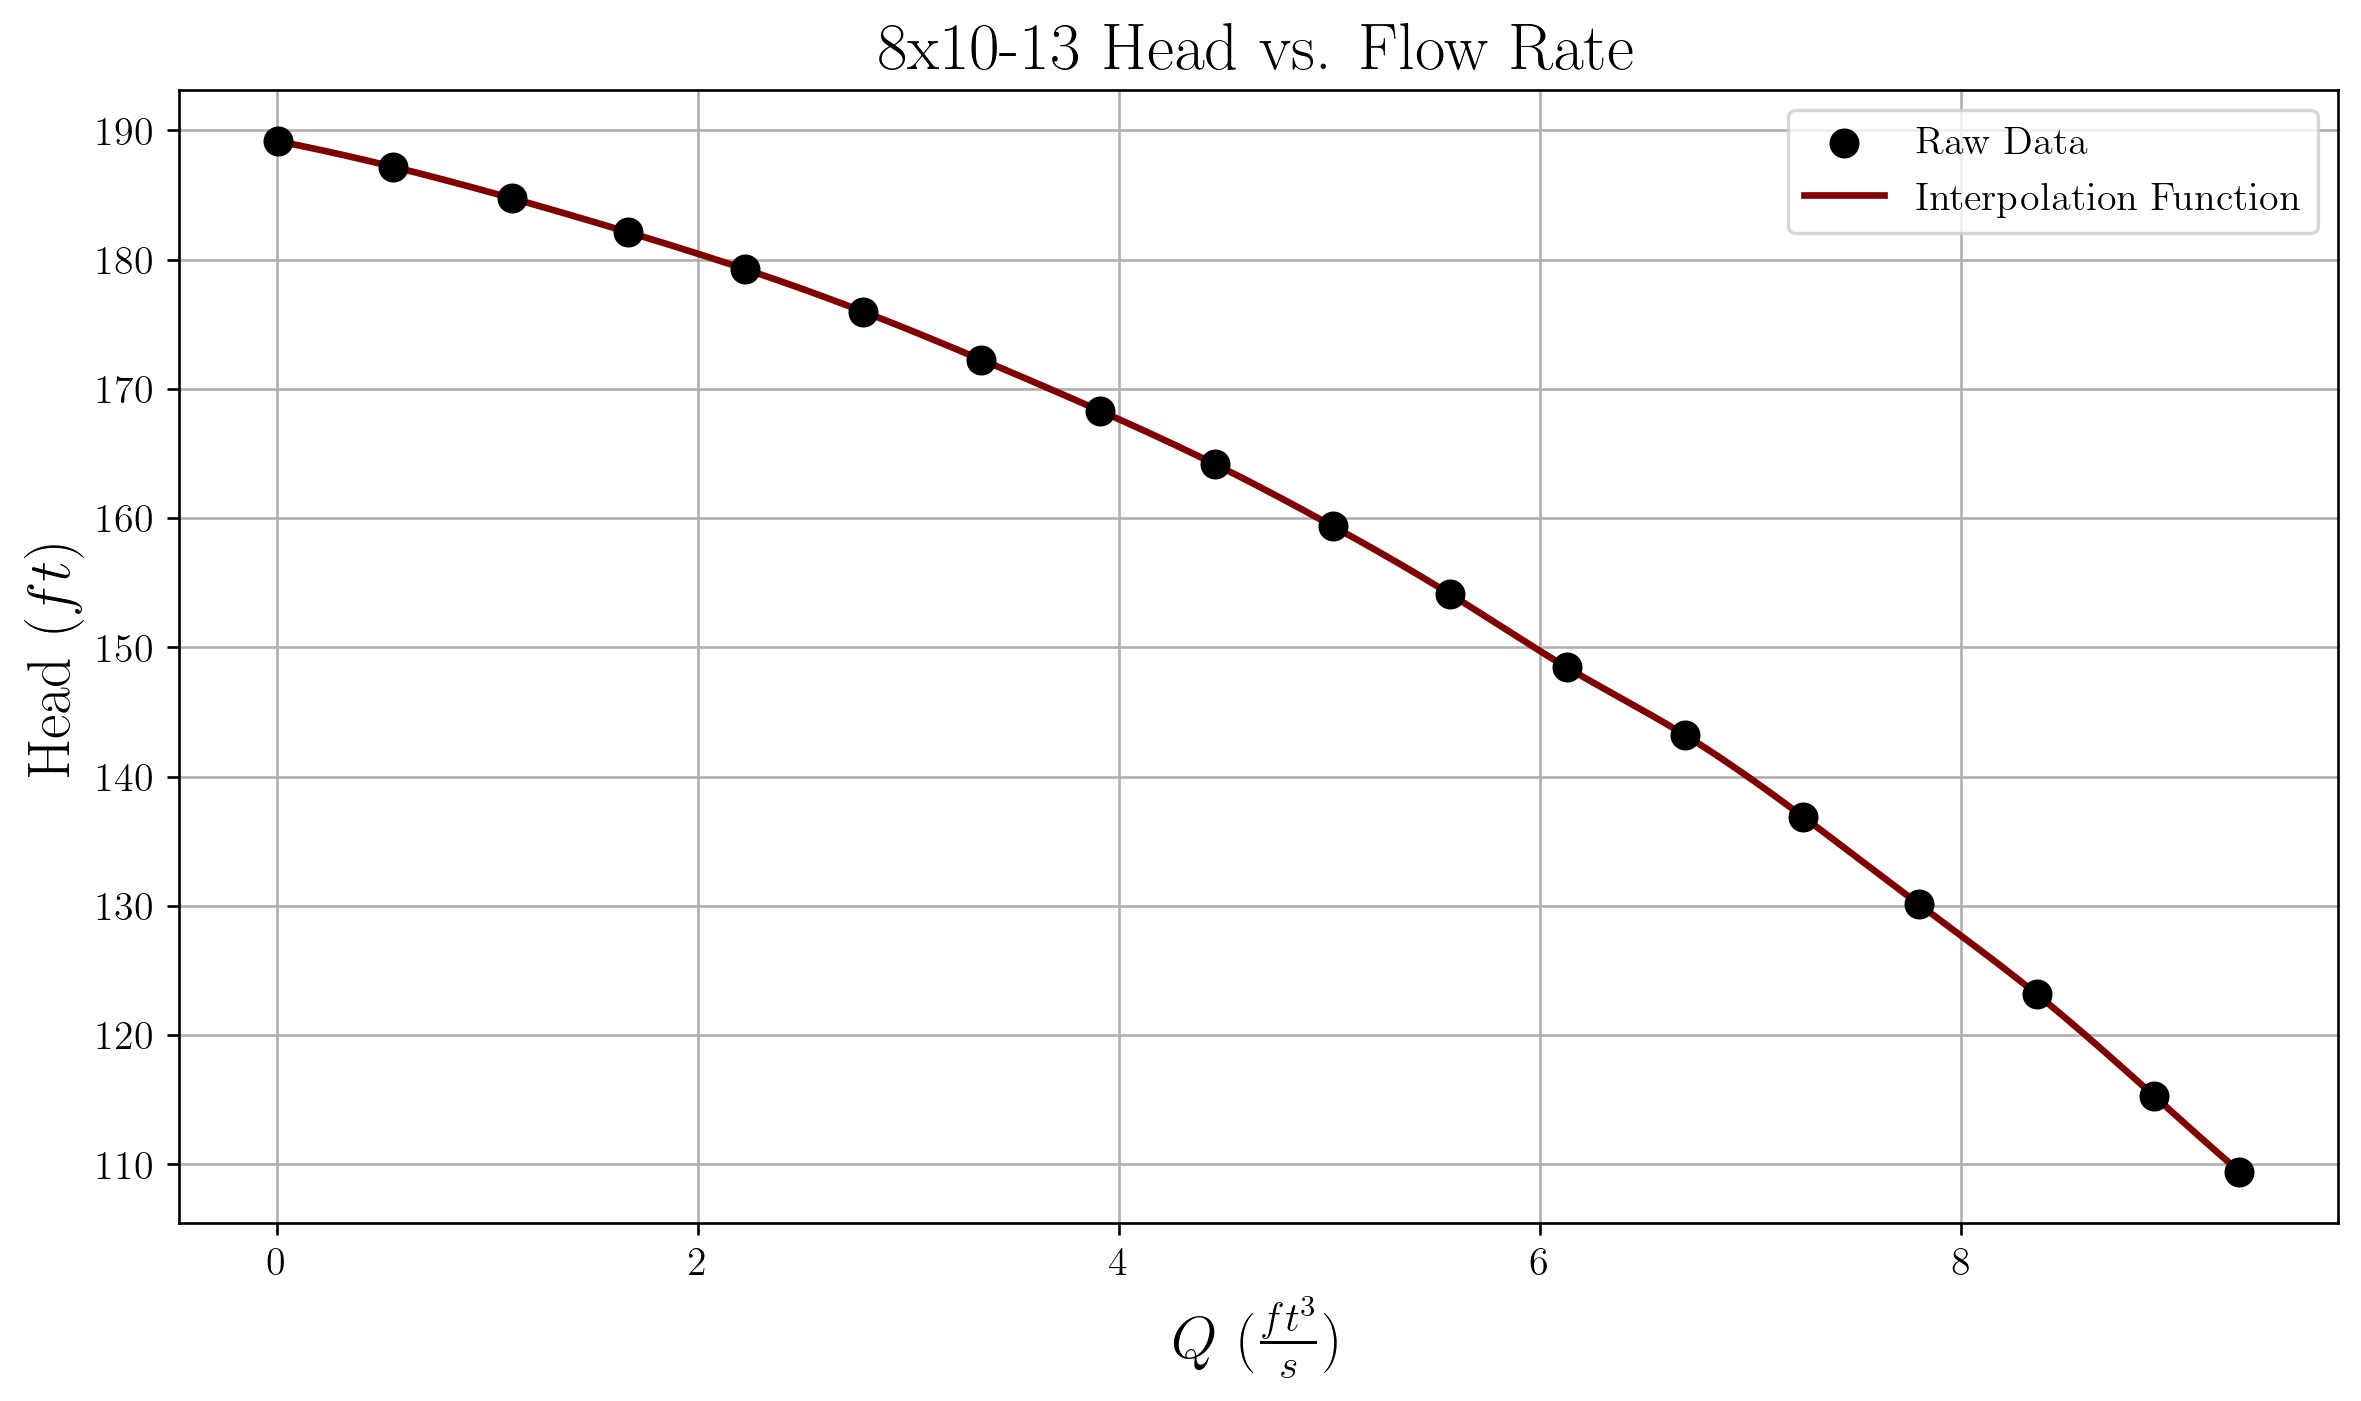

In [9]:
# Getting the head vs flow rate for the parallel arrangement
flow_1780 = np.array([1.8450184501847389, 248.15498154981583, 500, 749.077490774908, 998.1549815498156, 1250, 1501.8450184501844, 1753.6900369003688,  2000, 2251.845018450185, 2500.9225092250927, 2750, 3001.8450184501844, 3253.6900369003693, 3500, 3751.8450184501844, 4000.9225092250936, 4183.579335793357])/(7.48052*60)  # ft^3/sec

head_1780 = np.array([189.159891598916, 187.1730717307173, 184.7518475184752, 182.11422114221145, 179.25979259792604, 175.97135971359717, 172.24932249322498, 168.3104831048311, 164.15564155641562, 159.349593495935, 154.1103411034111, 148.4374843748438, 143.19783197831984, 136.87416874168747, 130.11770117701184, 123.14363143631445, 115.30275302753029, 109.42269422694235])  # ft

Ws_1780 = interp1d(flow_1780, head_1780, kind='cubic', fill_value='extrapolate')  # extrapolate is specified in case there are values that are not within the domain given
Q_values = np.linspace(0, flow_1780[-1], 1000)

plt.scatter(flow_1780, head_1780, zorder=3, color='black', label='Raw Data')
plt.plot(Q_values, Ws_1780(Q_values), label='Interpolation Function')
plt.xlabel(r'$Q$ ($\frac{ft^3}{s}$)')
plt.ylabel(r'Head ($ft$)')
plt.title('8x10-13 Head vs. Flow Rate')
plt.legend()
plt.show()

### Both Parallel Pumps Working
With both parallel pumps in use, the $W_s$ function takes in $\frac{Q_1}{2}$, since the flow splits due to the parallel arrangement.

In [10]:
def rating_1780(x, b2, b4, b7, b10):
    Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11 = x
    # all expressions need to be set to zero
    return [
        Q1 - Q2 - Q3,
        Q6 - Q2 - Q4,
        Q3 - Q4 - Q5,
        Q5 - Q10 - Q7,
        Q7 - Q8 - Q9,
        Q11 - Q6 - Q7,
        K1*Q2*abs(Q2) + p2.h(Q2) + p6.h(Q6) + p11.h(Q11) + p1.h(Q1) - Ws_1780(Q1/2) + 0.1*Q1*abs(Q1) - b2,
        p4.h(Q4) + K3*Q4*abs(Q4) - p2.h(Q2) - K1*Q2*abs(Q2) + p3.h(Q3) + b2 - b4,
        p7.h(Q7) + p8.h(Q8) + K4*Q8*abs(Q8) - p6.h(Q6) - p4.h(Q4) - K3*Q4*abs(Q4) + p5.h(Q5) + b4 - b7,
        p9.h(Q9) + K4*Q9*abs(Q9) - p8.h(Q8) - K4*Q8*abs(Q8),
        p10.h(Q10) + K2*Q10*abs(Q10) - p11.h(Q11) - p9.h(Q9) - K4*Q9*abs(Q9) - p7.h(Q7) + b7 - b10
    ]

solution_1780 = fsolve(rating_1780, Q_guess, args=(*b, ))
solution_1780  # cfs

array([10.95467097,  2.7897723 ,  8.16489867,  2.74885098,  5.41604769,
        5.53862328,  2.62502059,  1.31629343,  1.30872716,  2.7910271 ,
        8.16364387])

Applying the percent change,

In [11]:
(solution_1780 - balanced_solution)/balanced_solution*100

array([2.45153862, 2.82945562, 2.32304833, 1.31220935, 2.84384381,
       2.07079913, 2.84766771, 2.8478589 , 2.84747541, 2.84024762,
       2.31931802])

All the flow rates exceed the minimum requirements, but are within 3% difference (not excessive). This arrangement, therefore, is suitable. The power needed at this flow rate and head may be calculated using an 80% efficiency, which is the efficiency along the 13.25" line from Figure 7 at the slightly greater flow rate value.

In [12]:
# getting power
eta = 0.8
power = (rho*solution_1780[0]/2*Ws_1780(solution_1780[0]/2)*32.174)/eta
power_hp = power/550
power_hp  # hp

92.74532572902628

This is the power for one pump. Multiplying this by 2 will result in the total power.

In [13]:
power_hp_1780 = power_hp*2
power_hp_1780

185.49065145805255

Thus, the power for the parallel arrangement is 185.5 hp.

### One Parallel Pump Working
For only one parallel pump working, the system of equations is the same, but the head function receives all of $Q_1$ instead of $\frac{Q_1}{2}$.

In [14]:
def rating_1780_one(x, b2, b4, b7, b10):
    Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8, Q9, Q10, Q11 = x
    # all expressions need to be set to zero
    return [
        Q1 - Q2 - Q3,
        Q6 - Q2 - Q4,
        Q3 - Q4 - Q5,
        Q5 - Q10 - Q7,
        Q7 - Q8 - Q9,
        Q11 - Q6 - Q7,
        K1*Q2*abs(Q2) + p2.h(Q2) + p6.h(Q6) + p11.h(Q11) + p1.h(Q1) - Ws_1780(Q1) + 0.1*Q1*abs(Q1) - b2,
        p4.h(Q4) + K3*Q4*abs(Q4) - p2.h(Q2) - K1*Q2*abs(Q2) + p3.h(Q3) + b2 - b4,
        p7.h(Q7) + p8.h(Q8) + K4*Q8*abs(Q8) - p6.h(Q6) - p4.h(Q4) - K3*Q4*abs(Q4) + p5.h(Q5) + b4 - b7,
        p9.h(Q9) + K4*Q9*abs(Q9) - p8.h(Q8) - K4*Q8*abs(Q8),
        p10.h(Q10) + K2*Q10*abs(Q10) - p11.h(Q11) - p9.h(Q9) - K4*Q9*abs(Q9) - p7.h(Q7) + b7 - b10
    ]

solution_1780_one = fsolve(rating_1780_one, Q_guess, args=(*b, ))
solution_1780_one  # cfs

array([9.59897441, 2.3909079 , 7.2080665 , 2.57115627, 4.63691023,
       4.96206417, 2.24734304, 1.12689816, 1.12044488, 2.3895672 ,
       7.20940721])

Right away, it may be observed that the flow rates will fail to meet the minimum requirements, but this behavior is expected. The percent change is,

In [15]:
(solution_1780_one - balanced_solution)/balanced_solution*100

array([-10.22736328, -11.87246414,  -9.66803547,  -5.23694312,
       -11.95098354,  -8.55455775, -11.94964676, -11.95043535,
       -11.9488536 , -11.95224072,  -9.64064075])

Under these conditions, the power is,

In [16]:
power = (rho*solution_1780_one[0]*Ws_1780(solution_1780_one[0])*32.174)/eta
power_hp_1780_one = power/550
power_hp_1780_one  # hp

110.76699179570828

Thus, the power with only one of the 8x10-13 pumps in operation is 110.8 hp.

## Part E

In [17]:
pump_arrangement = ['Single 8x10-16H', 'Parallel 8x10-13', 'Single 8x10-13']
data = {
    'Head Values ($ft$)': [Ws_lamb(solution_1785[0]), Ws_1780(solution_1780[0]/2), Ws_1780(solution_1780_one[0])],
    'Total Power ($hp$)': [power_hp_1785, power_hp_1780, power_hp_1780_one],
    r'Total Capacity ($\frac{ft^3}{s}$)': [solution_1785[0], solution_1780[0], solution_1780_one[0]],
    r'Rotor Speed (RPM)': [1785, 1780, 1780]
}

display(Latex(
    r"""\begin{center}
    Table 4: Summary of Results
    \end{center}"""
))

df = pd.DataFrame(data, index=pump_arrangement)
display(Latex(fr'\begin{{center}}{df.to_latex(escape=False)}\end{{center}}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Table 4 shows a summary of the results for each arrangement of the pumps at some constant RPM. One major misconception, though, is that the pumps must operate at the given RPM. As stated earlier, this is not true, and the pumps can operate at numerous RPM values. This is evident in the fact that the Goulds performance charts have two different RPM performance plots for each pump size, indicating that the rotor speed is adjustable. That being said, there are an infinite amount of performance curves between RPM values.

Recall that the desired head for the pump is 145 ft, which is accomplished in the single main pump of 8x10-16H and the parallel arrangement of 8x10-13. The desired capacity ($Q_1$) is $10.692539\,\frac{ft^3}{s}$. The head and capacity values from Project 1 can be exactly reached by getting data for a lower RPM performance for each arrangement. The best way to approach this is to do a multidimensional interpolation of the data across the RPM values. This process is similar to interpolating between pressure tables for a superheated vapor in Thermodynamics. Consider the following code block, which gathers the head and flow rate data for the lower RPM option (1180 RPM) of the parallel arrangement and also generates a function that is capable of multidimensional interpolation.

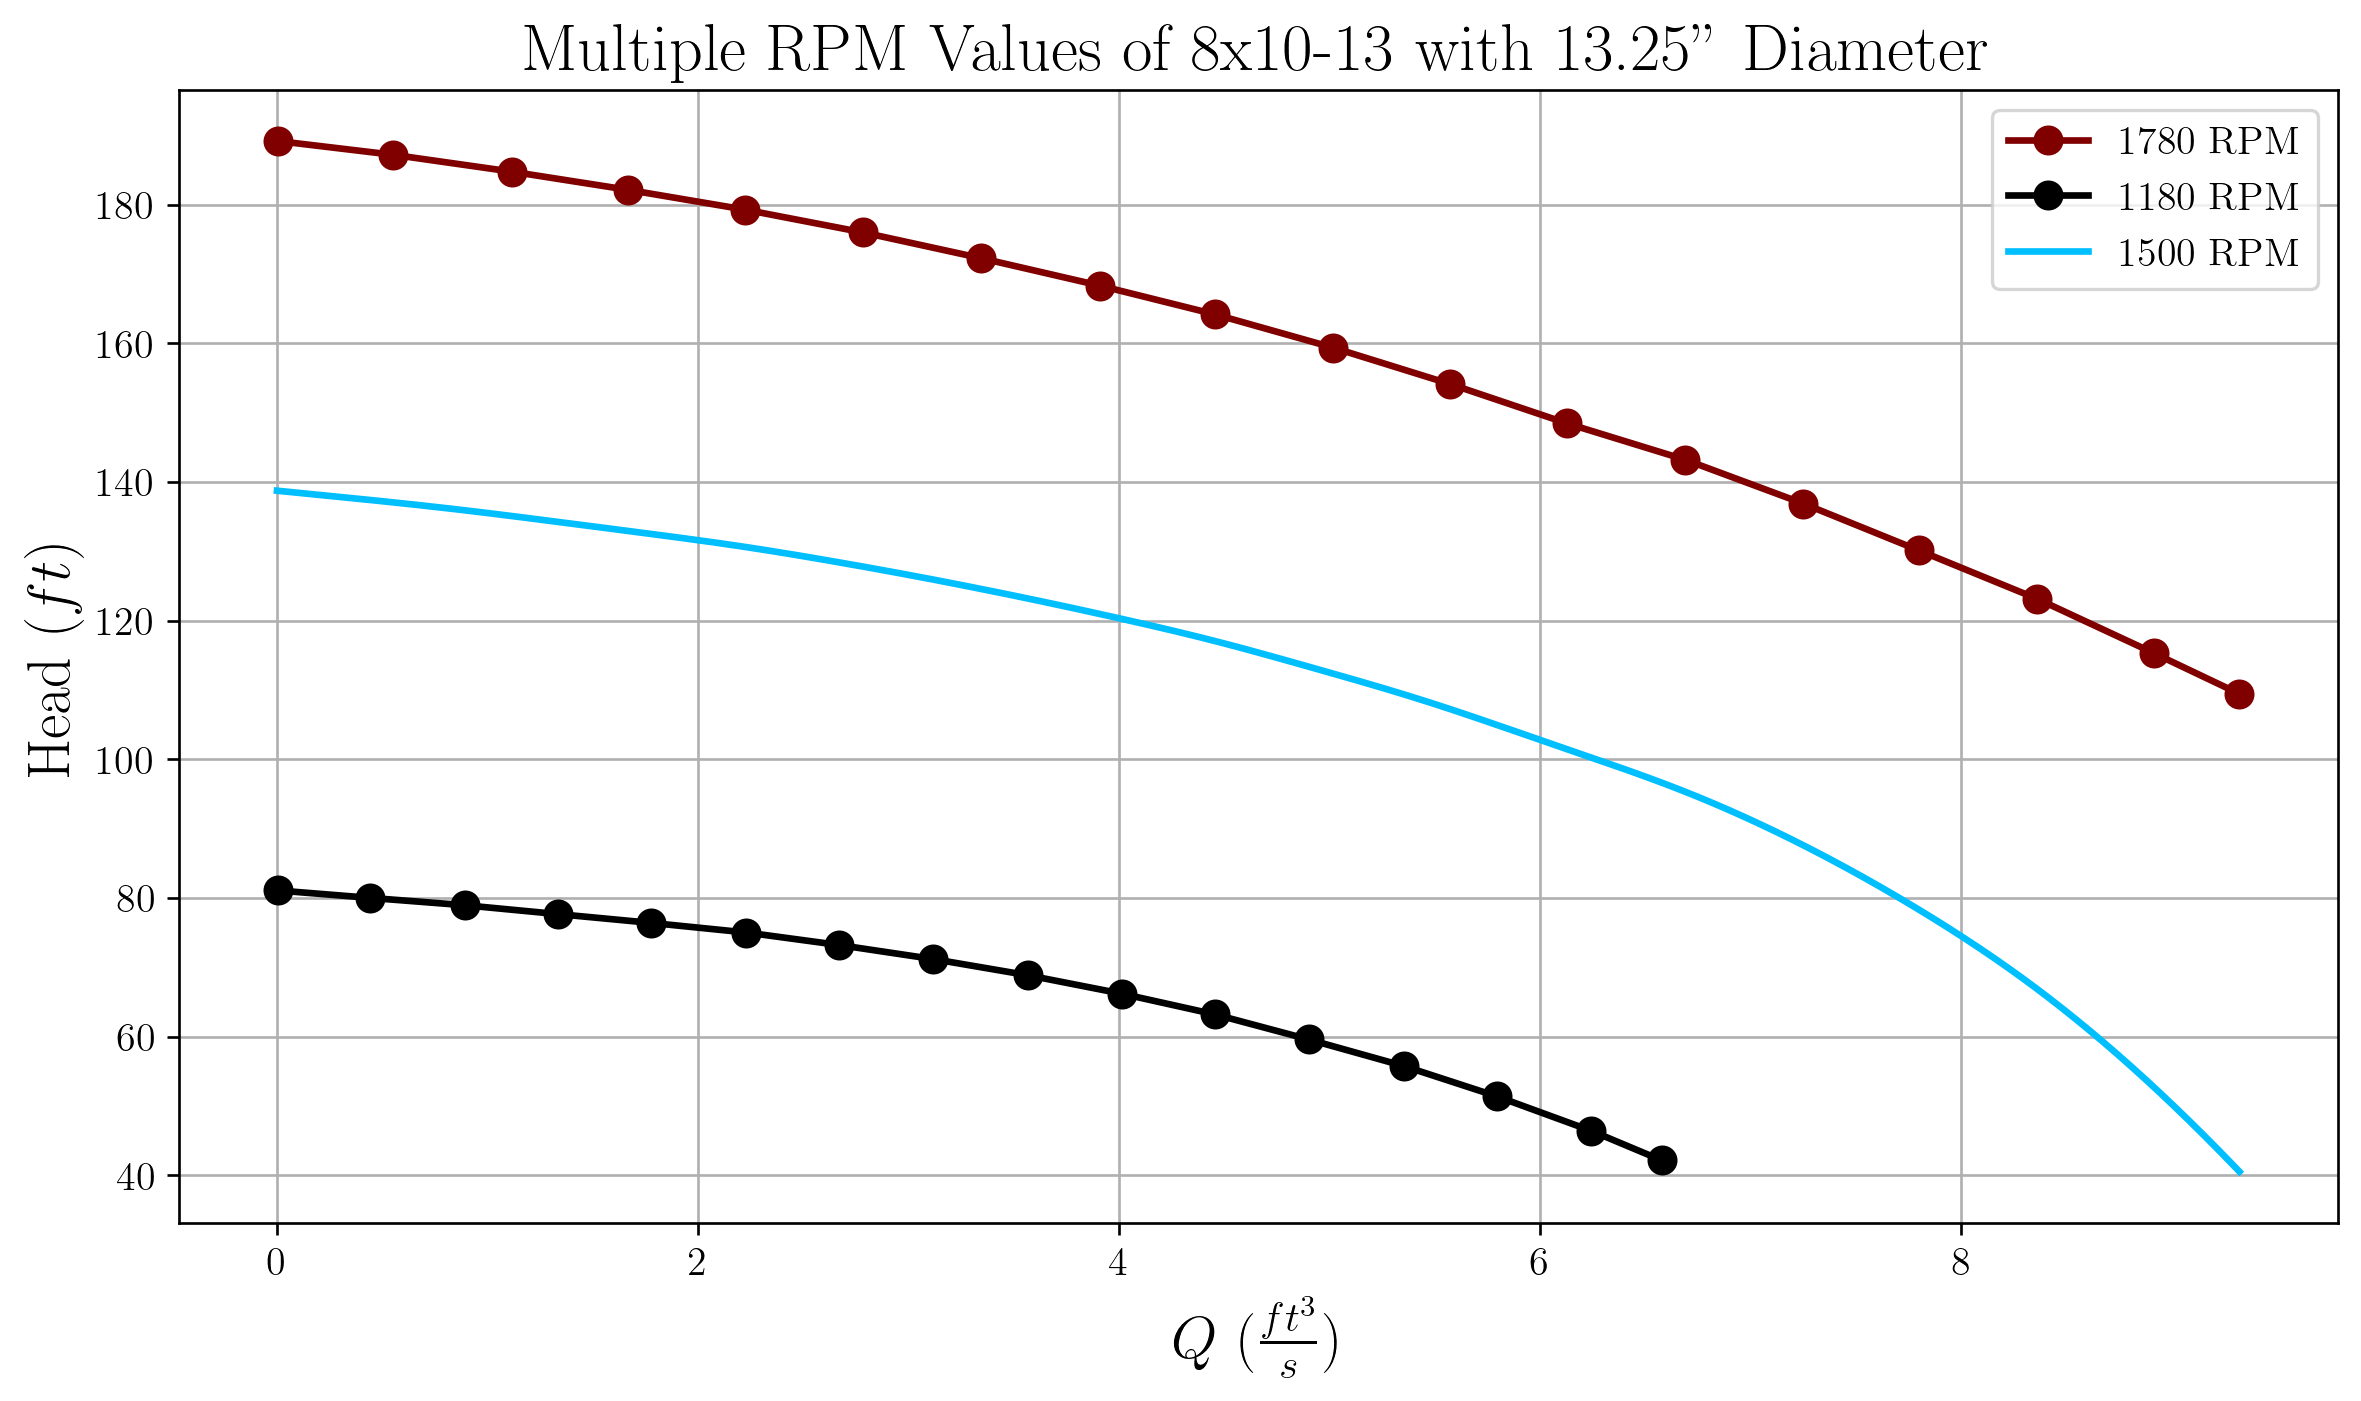

In [18]:
flow_1180 = np.array([1.8132366273798084, 197.6427923844061, 399.9999999999999, 598.005439709882, 798.1867633726201, 1000.5439709882139, 1198.5494106980962, 1398.7307343608338, 1601.0879419764283, 1801.269265639166, 1999.274705349048, 2199.4560290117865, 2401.8132366273803, 2599.8186763372623, 2802.1758839528557, 2952.311876699909
])/(7.48052*60)  # ft^3/s

head_1180 = np.array([81.06382978723403, 79.99999999999999, 78.93617021276594, 77.6595744680851, 76.38297872340424, 74.99999999999997, 73.1914893617021, 71.17021276595743, 68.82978723404253, 66.1702127659574, 63.1914893617021, 59.574468085106375, 55.744680851063805, 51.38297872340421, 46.382978723404236, 42.12765957446803
])  # ft

Ws_1180 = interp1d(flow_1180, head_1180, kind='cubic', fill_value='extrapolate')

def Ws_RPM(Q, RPM):
    """
    Returns the head between the two performance curves of the 8x10-13
    """
    return (Ws_1780(Q) - Ws_1180(Q))/(1780 - 1180)*(RPM - 1180) + Ws_1180(Q)

plt.plot(flow_1780, head_1780, marker='o', label='1780 RPM')
plt.plot(flow_1180, head_1180, marker='o', label='1180 RPM')
plt.plot(Q_values, Ws_RPM(Q_values, 1500), label='1500 RPM')
plt.xlabel(r'$Q$ ($\frac{ft^3}{s}$)')
plt.ylabel(r'Head ($ft$)')
plt.title('Multiple RPM Values of 8x10-13 with 13.25" Diameter')
plt.legend()
plt.show()

This is important because this means that there is no additional call for re-balancing the system, since the pumps can match the values from Project 1. From above, the interpolation between the two known RPM curves proves to be accurate for the 5 to 6 cfs range, which is the region of interest ($\frac{10.692539}{2}=5.35\,\frac{ft^3}{s}$). The RPM value that is able to accomplish the head and flow rate requirements may be calculated using the root finding method.

In [19]:
# Getting the RPM value
# Dividing the flow rate by two because this is the parallel arrangement
RPM_ = fsolve(lambda RPM__: Ws_RPM(balanced_solution[0]/2, RPM__) - 145, np.array([1500, ]))[0]
RPM_

1712.4394319551618

Thus, the 8x10-13 size can produce the exact values head and flow rate from Project 1 at 1712 RPM. Below is a graphical verification.

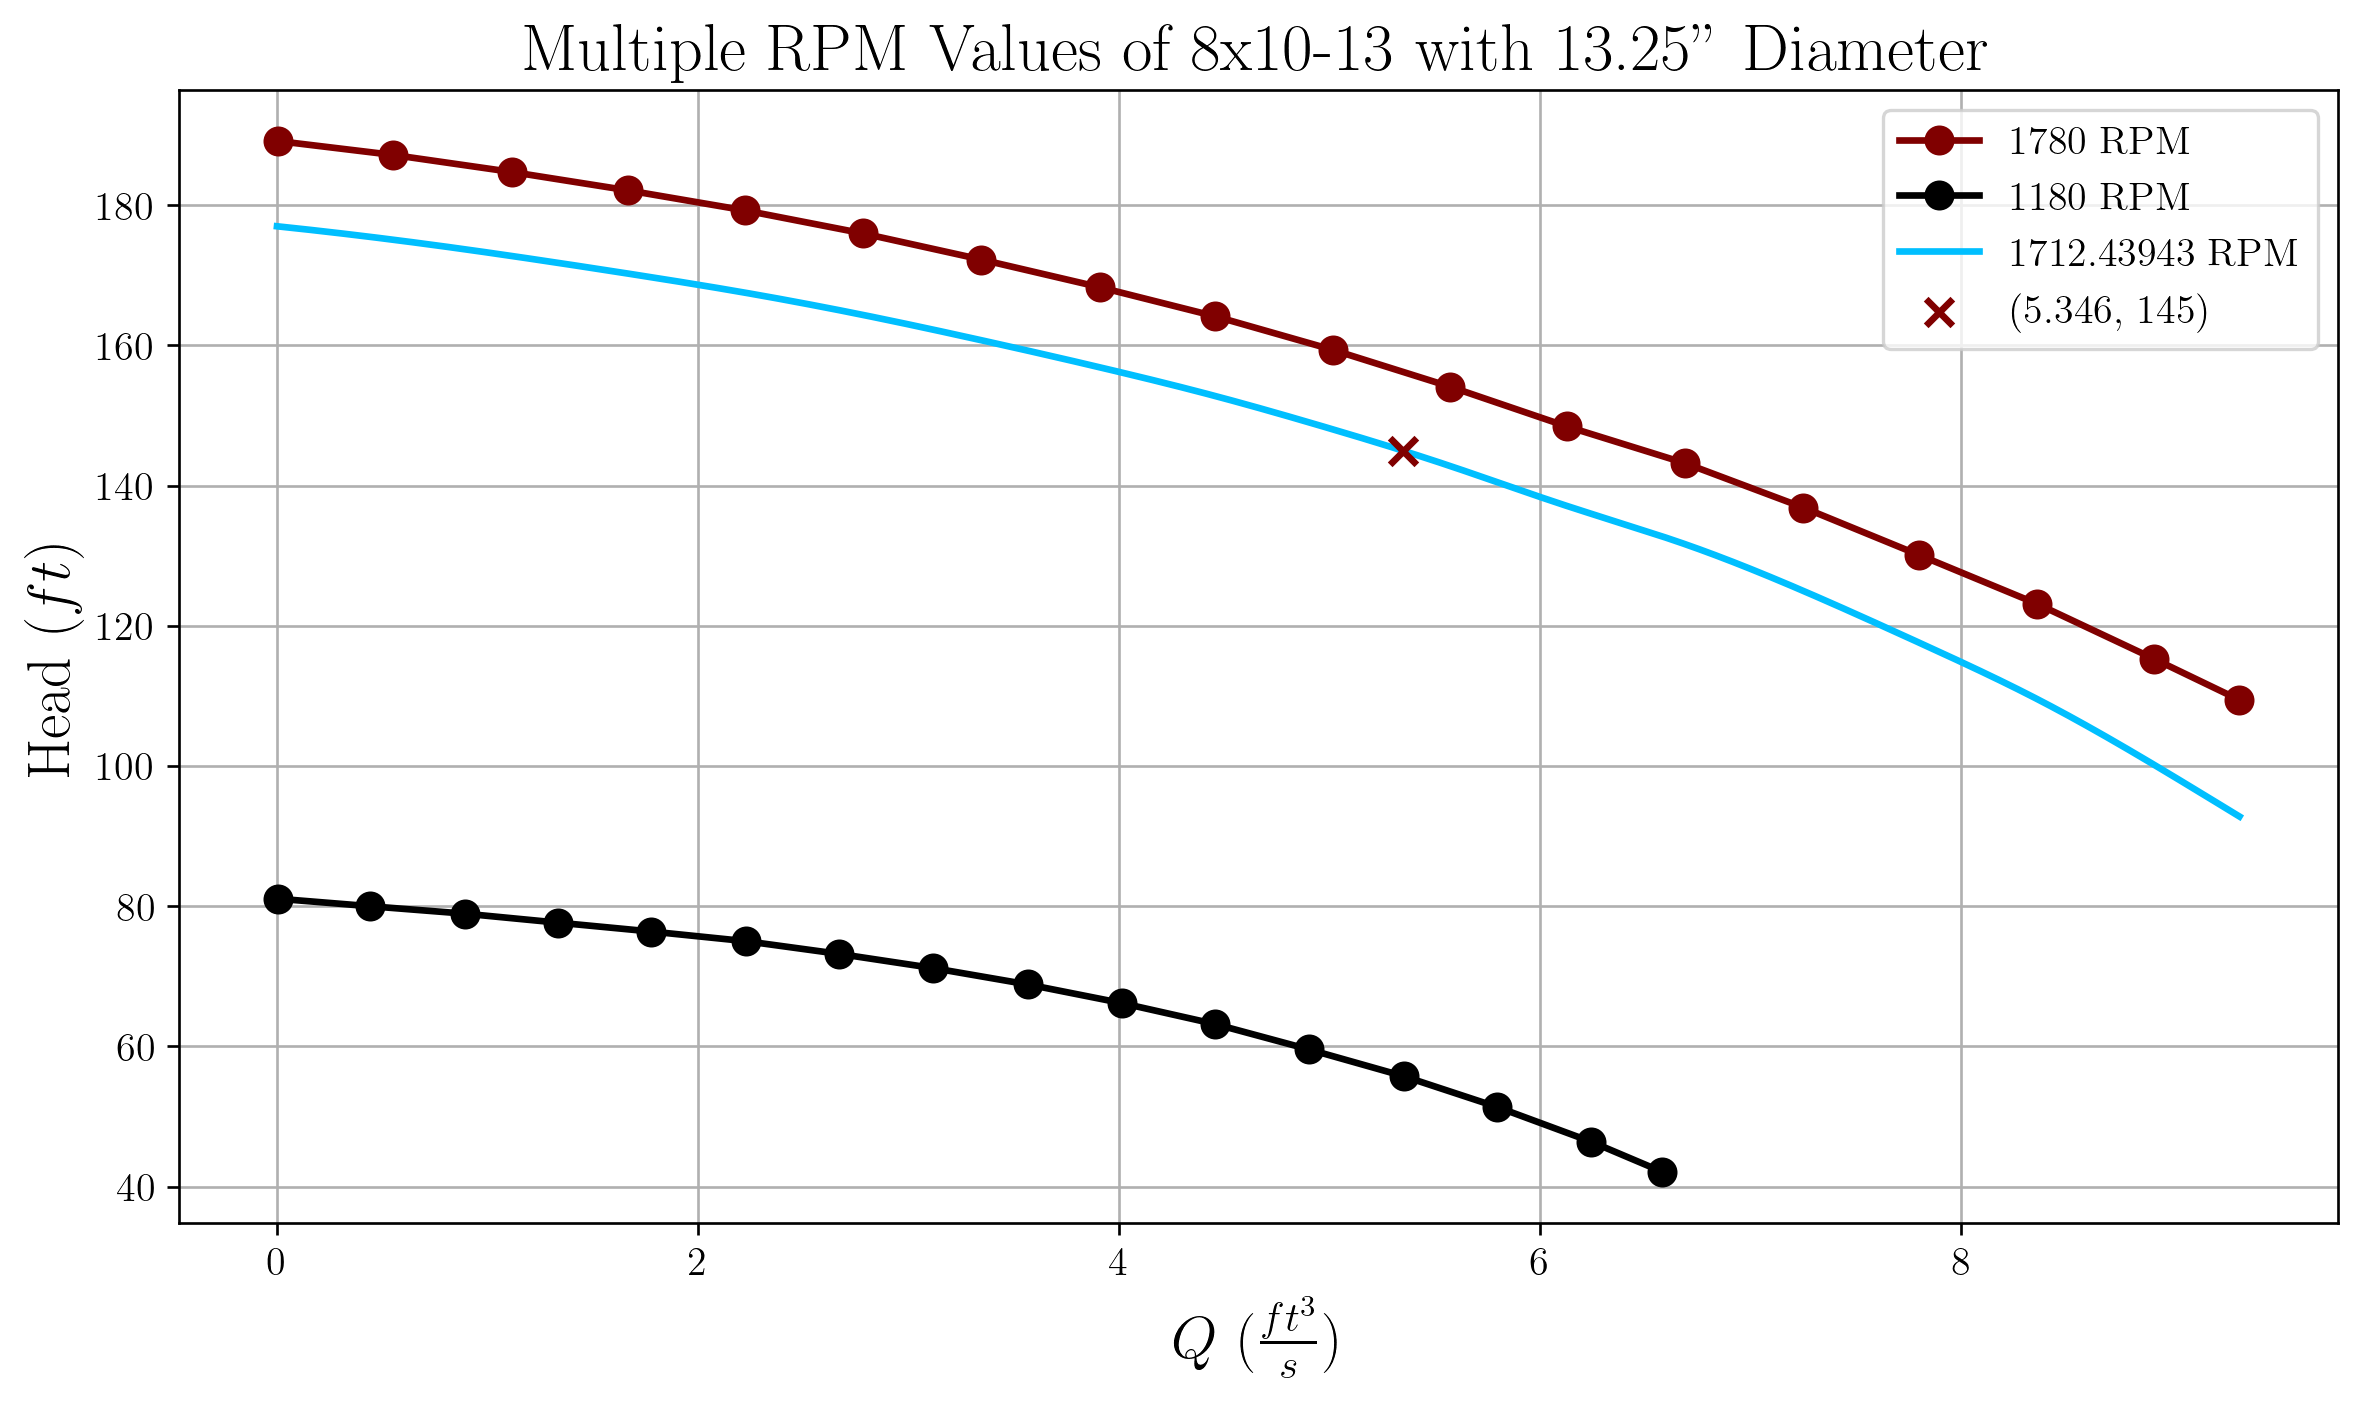

In [20]:
plt.plot(flow_1780, head_1780, marker='o', label='1780 RPM')
plt.plot(flow_1180, head_1180, marker='o', label='1180 RPM')
plt.plot(Q_values, Ws_RPM(Q_values, RPM_), label=f'{RPM_:.5f} RPM')
plt.scatter(balanced_solution[0]/2, 145, marker='x', zorder=3, label=f'({balanced_solution[0]/2:.3f}, {145})')
plt.xlabel(r'$Q$ ($\frac{ft^3}{s}$)')
plt.ylabel(r'Head ($ft$)')
plt.title('Multiple RPM Values of 8x10-13 with 13.25" Diameter')
plt.legend()
plt.show()

This same procedure can be used for the 8x10-16H single pump option, meaning that both selections are able to match the head requirements from Project 1.

# Pump Selection and Discussion
Part E proves that the single arrangement of 8x10-16H and the parallel arrangement of 8x10-13 are able to exactly meet the flow rate and head requirements from Project 1. Since power is a function of the flow rate and the head, the difference in power between the two are negligible because they can both operate at the same head and flow rate; however, power is also a function of efficiency. The efficiency for each pump is expected to be around the lower 80% range (as shown in Figure 5 and Figure 7), but can be better determined using the interpolation methods from Part E. The efficiency analysis will not be conducted in that manner, but it can be assumed that they are similar efficiencies, producing similar power ratings.

The deciding factor, then, is the convenience and design for failure. This means that the **parallel arrangement of the 8x10-13** is the pump selection for the mainline pump because it accounts for failure. The results from Part D and Table 4 show that the elimination of one of the pumps in parallel and operating at the upper range RPM value of 1780 RPM is insufficient for the required head and flow rates; however, this does still allow for the system to be operational. Also, the 1780 RPM may not be the absolute maximum RPM for the pump, meaning it can operate at a higher RPM value for a short time while the other pump is being fixed. The following code block will get an approximation of this scenario.

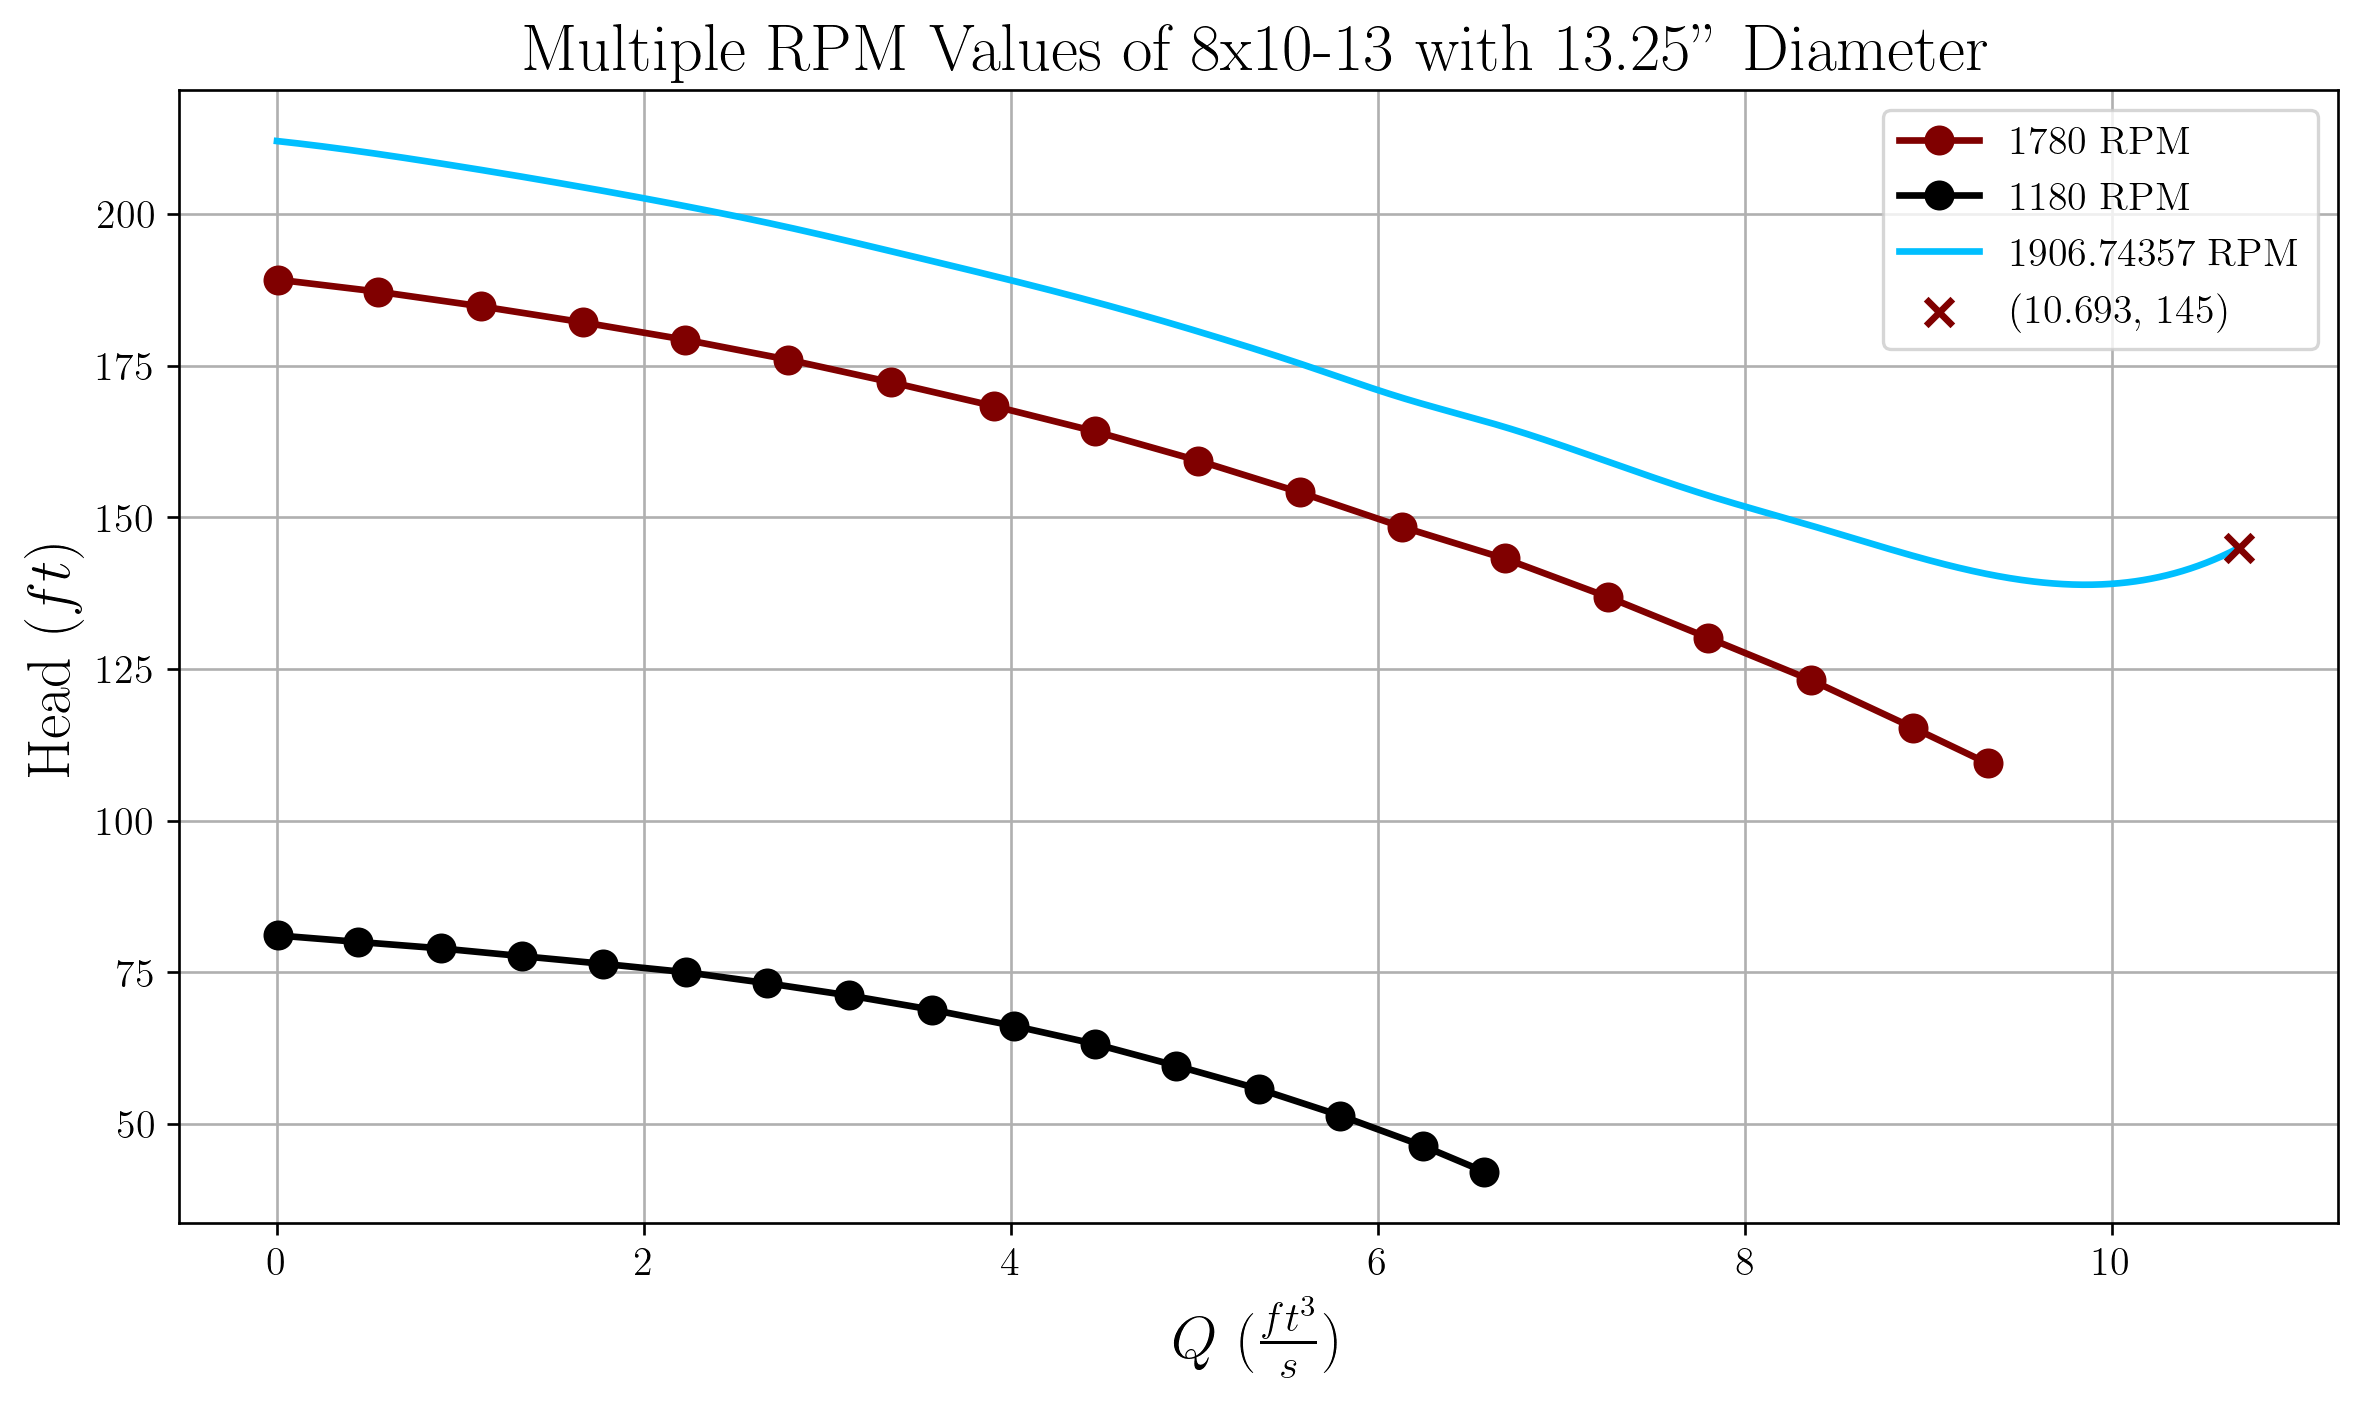

In [21]:
RPM_needed = fsolve(lambda RPM__: Ws_RPM(balanced_solution[0], RPM__) - 145, np.array([1500, ]))[0]
Q_values = np.linspace(0, balanced_solution[0], 1000)

plt.plot(flow_1780, head_1780, marker='o', label='1780 RPM')
plt.plot(flow_1180, head_1180, marker='o', label='1180 RPM')
plt.plot(Q_values, Ws_RPM(Q_values, RPM_needed), label=f'{RPM_needed:.5f} RPM')
plt.scatter(balanced_solution[0], 145, marker='x', zorder=3, label=f'({balanced_solution[0]:.3f}, {145})')
plt.xlabel(r'$Q$ ($\frac{ft^3}{s}$)')
plt.ylabel(r'Head ($ft$)')
plt.title('Multiple RPM Values of 8x10-13 with 13.25" Diameter')
plt.legend()
plt.show()

The resulting RPM for the single working pump in the parallel arrangement must be around 1900 RPM in order to meet the Project 1 boundaries. Note that the range for this flow rate is out of bounds of the data shown above, which means that the point was extrapolated. The extrapolated value, however, appears to be a more conservative value than what it actually would be, so it may be assumed that a lower value of the RPM can result in the head required. All this to say, the single arrangement of the 8x10-13 pump may be able to operate at this RPM for a short amount of time, leaving the system able to sustain the requirements across the air handling units.